In [1]:
from math import sin, cos, sqrt, atan2, radians

import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

In [2]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6373.0

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

def calculate_stderror(Y, Y_pred):
    residuals = pd.DataFrame(Y - Y_pred)
    residuals['c'] = residuals.iloc[:, 0]**2
    sq = residuals['c']
    standard_error = (sum(sq)/(10-2))**0.5
    return standard_error

def calculate_gradient(x1, y1, x2, y2):
    dividend = y2- y1
    divisor = x2 - x1

    return dividend / divisor

In [3]:
pd.set_option('mode.chained_assignment', None)

In [4]:
orders = pd.read_csv('out/orders_merged.csv')

In [5]:
orders["product_volume_cm3"] = orders["product_length_cm"] * orders["product_height_cm"] * orders["product_width_cm"]
orders["buyer_seller_distance_km"] = orders.apply(
    lambda x: haversine(
        x["seller_lat"], x["seller_lng"],
        x["customer_lat"], x["customer_lng"],
    ),
    axis=1
)
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['duration'] = orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]
orders["duration_days"] = orders["duration"].dt.days

In [6]:
orders.columns

Index(['Unnamed: 0', 'order_id', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'order_item_id',
       'product_id', 'seller_id', 'shipping_limit_date', 'price',
       'freight_value', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'customer_lat', 'customer_lng',
       'seller_lat', 'seller_lng', 'prod

## Trending Products

<AxesSubplot:ylabel='product_category_name_english'>

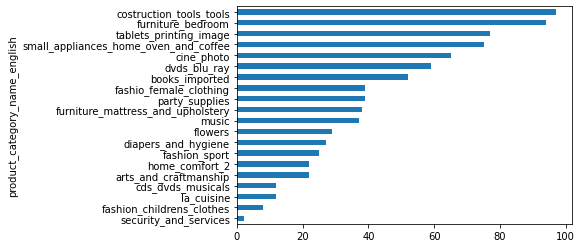

In [7]:
orders.groupby("product_category_name_english").size().sort_values()[:20].plot(kind='barh')

## Weight to duration of delivery

In [8]:
analyze = orders[[
    "order_purchase_timestamp", "order_delivered_customer_date",
    "product_weight_g",
    "product_length_cm", "product_height_cm", "product_width_cm",
    "seller_lat", "seller_lng",
    "customer_lat", "customer_lng",
    "review_score"
]]

In [9]:
analyze['order_delivered_customer_date'] = pd.to_datetime(analyze['order_delivered_customer_date'])
analyze['order_purchase_timestamp'] = pd.to_datetime(analyze['order_purchase_timestamp'])
analyze['duration'] = analyze["order_delivered_customer_date"] - analyze["order_purchase_timestamp"]
analyze["duration_days"] = analyze["duration"].dt.days

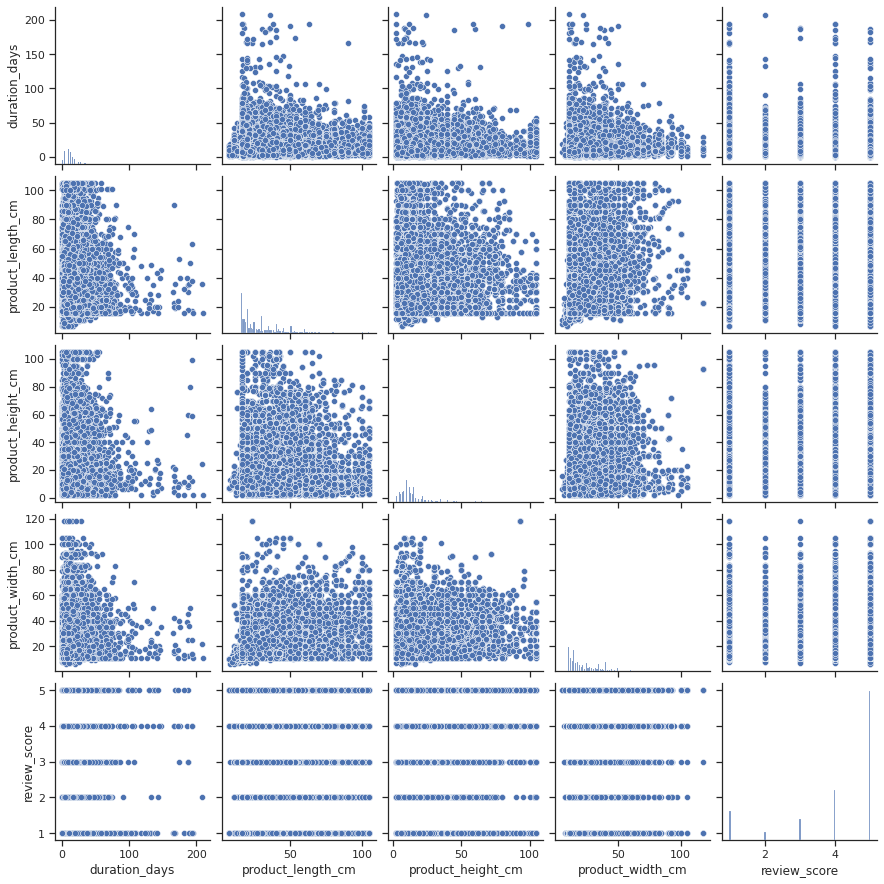

In [10]:
import seaborn as sns

sns.set_theme(style="ticks")

sns.pairplot(analyze[
  ["duration_days", "product_length_cm", "product_height_cm", "product_width_cm", "review_score"]
])

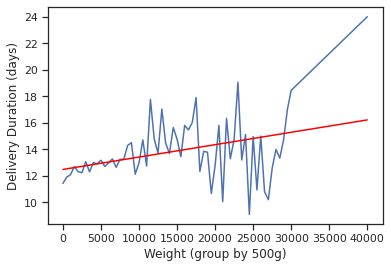

gradient: 0.00009338954673829462
stderr: 6.205028810732603


In [11]:
weight_group = 500
model = analyze["weight_group"] = (analyze["product_weight_g"] // weight_group) * weight_group
model = analyze.groupby("weight_group")["duration_days"].mean()
model = model.reset_index()

X = model["weight_group"].values.reshape(-1, 1)
Y = model["duration_days"].values.reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.plot(X, Y)
plt.plot(X, Y_pred, color='red')
plt.ylabel("Delivery Duration (days)")
plt.xlabel("Weight (group by 500g)")
plt.show()

print(f'gradient: {calculate_gradient(X[0][0], Y_pred[0][0], X[-1][0], Y_pred[-1][0]):.20f}')
print(f'stderr: {calculate_stderror(Y, Y_pred)}')

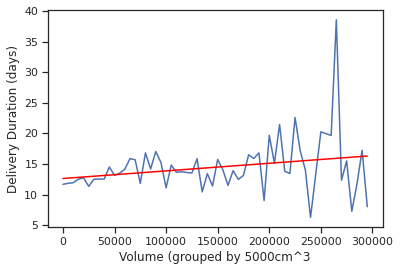

gradient: 0.00001246043165654071
stderr: 11.65745520654758


In [12]:
analyze["product_volume_cm3"] = analyze["product_length_cm"] * analyze["product_height_cm"] * analyze["product_width_cm"]
analyze["product_volume_m3"] = analyze["product_volume_cm3"] * 1e-6

volume_group = 5000 # size of a bowling ball
analyze["volume_group"] = (analyze["product_volume_cm3"] // volume_group) * volume_group
model = analyze.groupby("volume_group")["duration_days"].mean()
model = model.reset_index()

X = model["volume_group"].values.reshape(-1, 1)
Y = model["duration_days"].values.reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.plot(X, Y)
plt.plot(X, Y_pred, color='red')
plt.ylabel("Delivery Duration (days)")
plt.xlabel("Volume (grouped by 5000cm^3")
plt.show()

print(f'gradient: {calculate_gradient(X[0][0], Y_pred[0][0], X[-1][0], Y_pred[-1][0]):.20f}')
print(f'stderr: {calculate_stderror(Y, Y_pred)}')

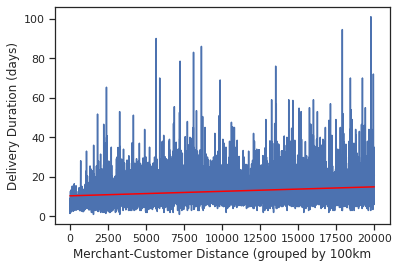

gradient: 0.00022719825846620483
stderr: 274.899278499592


In [13]:
analyze["buyer_seller_distance_km"] = analyze.apply(
    lambda x: haversine(
        x["seller_lat"], x["seller_lng"],
        x["customer_lat"], x["customer_lng"],
    ),
    axis=1
)

distance_group = 1
analyze["distance_group"] = (analyze["buyer_seller_distance_km"] // distance_group) * distance_group
model = analyze.groupby("distance_group")["duration_days"].mean()
model = model.reset_index()

model = model.dropna()

X = model["distance_group"].values.reshape(-1, 1)
Y = model["duration_days"].values.reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.plot(X, Y)
plt.plot(X, Y_pred, color='red')
plt.ylabel("Delivery Duration (days)")
plt.xlabel("Merchant-Customer Distance (grouped by 100km")
plt.show()

print(f'gradient: {calculate_gradient(X[0][0], Y_pred[0][0], X[-1][0], Y_pred[-1][0]):.20f}')
print(f'stderr: {calculate_stderror(Y, Y_pred)}')

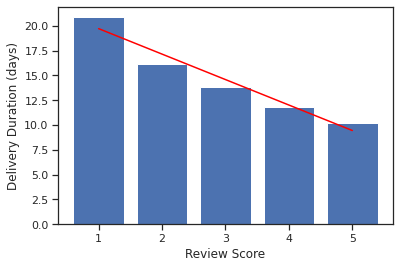

gradient: -2.56530341388258342761
stderr: 0.6589531010077664


In [14]:
model = analyze.groupby("review_score")["duration_days"].mean()
model = model.reset_index()

plt.bar(model["review_score"], model["duration_days"])
plt.ylabel("Delivery Duration (days)")
plt.xlabel("Review Score")

X = model["review_score"].values.reshape(-1, 1)
Y = model["duration_days"].values.reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.plot(X, Y_pred, color='red')
plt.show()

print(f'gradient: {calculate_gradient(X[0][0], Y_pred[0][0], X[-1][0], Y_pred[-1][0]):.20f}')
print(f'stderr: {calculate_stderror(Y, Y_pred)}')

## Feature Selection

In [15]:
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['duration'] = orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]
orders["duration_days"] = orders["duration"].dt.days

In [16]:
label_fit = orders['payment_type'].sort_values(ascending=True).unique()
le= preprocessing.LabelEncoder()
le.fit(label_fit)
orders['payment_type'] = le.transform(orders['payment_type'])

In [17]:
training = orders.dropna()

Y = training["duration_days"]
X = training[[
    "payment_type", "payment_installments", "payment_value",
    "review_score", "price", "freight_value", "buyer_seller_distance_km",
    "product_length_cm", "product_height_cm", "product_width_cm", "product_volume_cm3"
]]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.00000001)

In [19]:
sel = SelectFromModel(
    RandomForestClassifier(n_estimators=100)
)
sel.fit(X_train, y_train)
# sel.get_support()

SelectFromModel(estimator=RandomForestClassifier())

In [20]:
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

Index(['payment_value', 'price', 'freight_value', 'buyer_seller_distance_km',
       'product_volume_cm3'],
      dtype='object')


<AxesSubplot:ylabel='feature'>

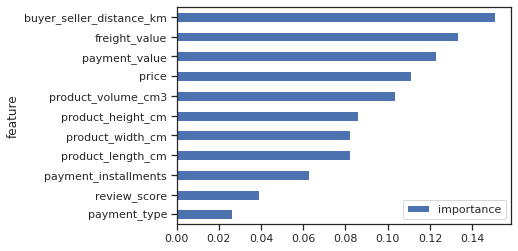

In [21]:
feature_importance = pd.DataFrame()

importance = sel.estimator_.feature_importances_.ravel()
for i, feature in enumerate(sel.feature_names_in_):
    feature_importance = feature_importance.append({
        "feature": feature,
        "importance": importance[i],
    }, ignore_index=True)

feature_importance = feature_importance.set_index("feature")
feature_importance.sort_values(by="importance")[:15].plot(kind='barh')

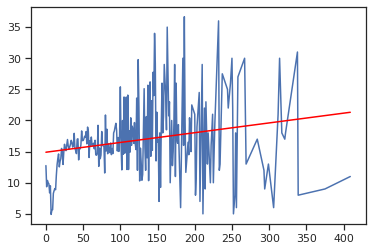

gradient: 0.01568799126443624903
stderr: 31.56740795008997


In [22]:
distance_group = 1
orders["freight_value_group"] = (orders["freight_value"] // distance_group) * distance_group
model = orders.groupby("freight_value_group")["duration_days"].mean()
model = model.reset_index()
model = model.dropna()

X = model["freight_value_group"].values.reshape(-1, 1)
Y = model["duration_days"].values.reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.plot(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

print(f'gradient: {calculate_gradient(X[0][0], Y_pred[0][0], X[-1][0], Y_pred[-1][0]):.20f}')
print(f'stderr: {calculate_stderror(Y, Y_pred)}')

In [23]:
temp = orders[orders["duration_days"] > orders["duration_days"].quantile(0.80)]
temp["customer_state"].value_counts()

RJ    3269
SP    2796
MG    1644
BA    1466
RS    1439
SC     987
PR     698
CE     665
PE     638
PA     596
ES     570
GO     533
MA     405
DF     387
MT     358
PB     264
AL     263
RN     206
PI     205
MS     200
SE     168
RO     119
AM     113
TO     105
AP      54
AC      42
RR      27
Name: customer_state, dtype: int64

# Box Sizes

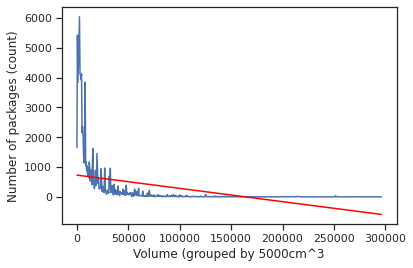

gradient: -0.00445204190977290231
stderr: 4920.890594927137


In [24]:
analyze["product_volume_cm3"] = analyze["product_length_cm"] * analyze["product_height_cm"] * analyze["product_width_cm"]
analyze["product_volume_m3"] = analyze["product_volume_cm3"] * 1e-6

volume_group = 500 # size of a bowling ball
analyze["volume_group"] = (analyze["product_volume_cm3"] // volume_group) * volume_group

model = analyze.groupby("volume_group")[["volume_group"]].count().rename(columns={
  "volume_group": "count"
}).reset_index()

X = model["volume_group"].values.reshape(-1, 1)
Y = model["count"].values.reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.plot(X, Y)
plt.plot(X, Y_pred, color='red')
plt.ylabel("Number of packages (count)")
plt.xlabel("Volume (grouped by 5000cm^3")
plt.show()

print(f'gradient: {calculate_gradient(X[0][0], Y_pred[0][0], X[-1][0], Y_pred[-1][0]):.20f}')
print(f'stderr: {calculate_stderror(Y, Y_pred)}')

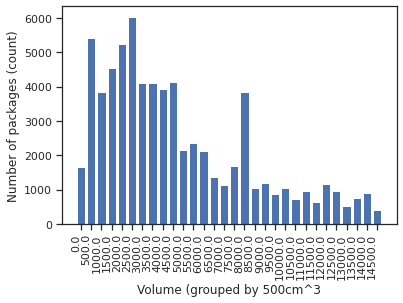

gradient: -0.31551234705228026201
stderr: 1918.6068377566417


In [25]:
X = model.head(30)["volume_group"]
Y = model.head(30)["count"]

plt.bar(X.astype("string"), Y)

X = X.values.reshape(-1, 1)
Y = Y.values.reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.ylabel("Number of packages (count)")
plt.xlabel("Volume (grouped by 500cm^3")
plt.xticks(rotation=90, ha='right')
plt.show()

print(f'gradient: {calculate_gradient(X[0][0], Y_pred[0][0], X[-1][0], Y_pred[-1][0]):.20f}')
print(f'stderr: {calculate_stderror(Y, Y_pred)}')

In [34]:
compare = analyze[["product_height_cm", "product_width_cm", "product_length_cm"]]

<AxesSubplot:>

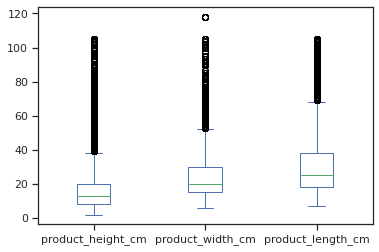

In [35]:
compare.plot.box()

<AxesSubplot:>

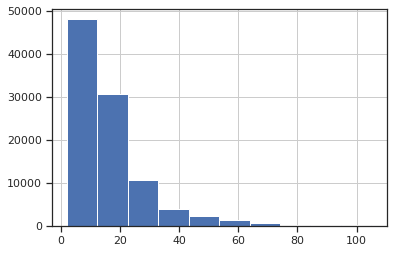

In [39]:
analyze["product_height_cm"].hist()

<AxesSubplot:>

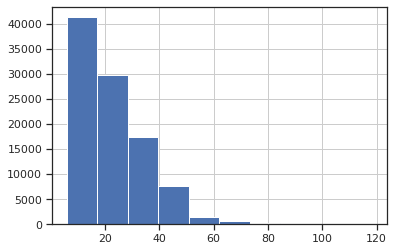

In [40]:
analyze["product_width_cm"].hist()

<AxesSubplot:>

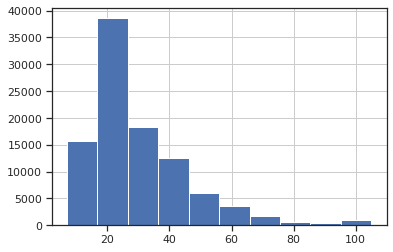

In [41]:
analyze["product_length_cm"].hist()

<AxesSubplot:>

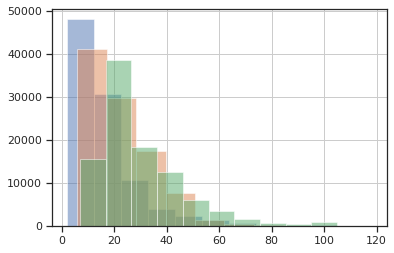

In [44]:
analyze["product_height_cm"].hist(alpha=0.8)
analyze["product_width_cm"].hist(alpha=0.8)
analyze["product_length_cm"].hist(alpha=0.8)

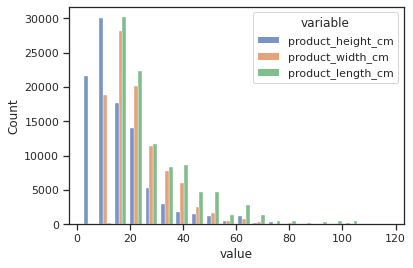

In [38]:
sns.histplot(compare.melt(), x='value', hue='variable', multiple='dodge', shrink=.75, bins=20);

<BarContainer object of 50 artists>

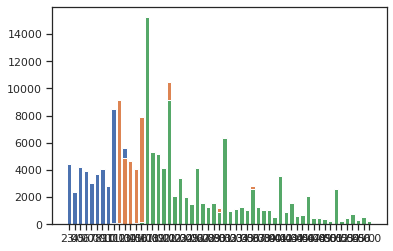

In [27]:
volume_group = 1
analyze["height_group"] = (analyze["product_height_cm"] // volume_group) * volume_group
analyze["width_group"] = (analyze["product_width_cm"] // volume_group) * volume_group
analyze["length_group"] = (analyze["product_length_cm"] // volume_group) * volume_group

model_height = analyze.groupby("height_group")[["height_group"]].count().rename(columns={
  "height_group": "count"
}).reset_index()
model_width = analyze.groupby("width_group")[["width_group"]].count().rename(columns={
  "width_group": "count"
}).reset_index()
model_length = analyze.groupby("length_group")[["length_group"]].count().rename(columns={
  "length_group": "count"
}).reset_index()

X = model_height.head(50)["height_group"]
Y = model_height.head(50)["count"]
plt.bar(X.astype("string"), Y, label="height")

X = model_width.head(50)["width_group"]
Y = model_width.head(50)["count"]
plt.bar(X.astype("string"), Y, label="width")

X = model_length.head(50)["length_group"]
Y = model_length.head(50)["count"]
plt.bar(X.astype("string"), Y, label="length")